# Multimodel Breast Cancer Detection using Ensemble Learning

In [1]:
# Import Libraries
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Concatenate
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import joblib
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk
import threading

In [2]:
# Enable mixed precision for faster training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Define Dataset and Load Image

In [3]:
# Dataset Paths
mammogram_path = r"C:\Users\Dell\Desktop\Major project\Mammogram images"
cancer_path = os.path.join(mammogram_path, 'Cancer')
non_cancer_path = os.path.join(mammogram_path, 'Non-Cancer')

ultrasound_path = r"C:\Users\Dell\Desktop\Major project\Dataset_BUSI_with_GT"
ultrasound_cancer_path = os.path.join(ultrasound_path, 'cancer')
ultrasound_non_cancer_path = os.path.join(ultrasound_path, 'non-cancer')

In [4]:
# Function to load images
def load_images_from_folder(folder, label, img_size=(224, 224)):
    data = []
    print(f"Loading images from: {folder}")

    for root, _, files in os.walk(folder):
        for filename in files:
            if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
                img_path = os.path.join(root, filename)
                img = cv2.imread(img_path)

                if img is not None:
                    img = cv2.resize(img, img_size)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = img / 255.0  # Normalize
                    data.append((img, label))
                else:
                    print(f"Could not load: {img_path}")

    print(f"Total images loaded: {len(data)} from {folder}")
    return data

# Combine, Split and Computation of Class Weight

In [5]:
# Load Mammogram & Ultrasound Data
cancer_images = load_images_from_folder(cancer_path, label=1)
non_cancer_images = load_images_from_folder(non_cancer_path, label=0)
ultrasound_cancer_images = load_images_from_folder(ultrasound_cancer_path, label=1)
ultrasound_non_cancer_images = load_images_from_folder(ultrasound_non_cancer_path, label=0)

# Combine datasets
data = cancer_images + non_cancer_images + ultrasound_cancer_images + ultrasound_non_cancer_images
images, labels = zip(*data)
images = np.array(images, dtype=np.float32)
labels = np.array(labels, dtype=np.float32)

# Reshape labels to match model output
labels = labels.reshape(-1, 1)

Loading images from: C:\Users\Dell\Desktop\Major project\Mammogram images\Cancer
Total images loaded: 620 from C:\Users\Dell\Desktop\Major project\Mammogram images\Cancer
Loading images from: C:\Users\Dell\Desktop\Major project\Mammogram images\Non-Cancer
Total images loaded: 620 from C:\Users\Dell\Desktop\Major project\Mammogram images\Non-Cancer
Loading images from: C:\Users\Dell\Desktop\Major project\Dataset_BUSI_with_GT\cancer
Total images loaded: 1157 from C:\Users\Dell\Desktop\Major project\Dataset_BUSI_with_GT\cancer
Loading images from: C:\Users\Dell\Desktop\Major project\Dataset_BUSI_with_GT\non-cancer
Total images loaded: 1157 from C:\Users\Dell\Desktop\Major project\Dataset_BUSI_with_GT\non-cancer


In [6]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)
print(f"Training size: {X_train.shape}, Testing size: {X_test.shape}")

Training size: (2843, 224, 224, 3), Testing size: (711, 224, 224, 3)


In [7]:
# Compute Class Weights
labels_flat = labels.ravel()  # Convert to 1D array
class_weights = compute_class_weight("balanced", classes=np.unique(labels_flat), y=labels_flat)
class_weight_dict = {i: weight for i, weight in zip(np.unique(labels_flat), class_weights)}
print("Computed Class Weights:", class_weight_dict)

Computed Class Weights: {0.0: 1.0, 1.0: 1.0}


# Data Augmentation

In [8]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()

# Displaying of the Images

In [9]:
# Improved Image Display Function (Balanced Cancer & Non-Cancer)
def display_balanced_images(images, labels, grid_size=(4, 4)):
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(10, 10))

    labels_flat = labels.ravel()  # Flatten labels to 1D

    # Select equal number of Cancer (1) and Non-Cancer (0) images
    cancer_images = images[labels_flat == 1][:grid_size[0] * grid_size[1] // 2]
    non_cancer_images = images[labels_flat == 0][:grid_size[0] * grid_size[1] // 2]

    # Ensure we have enough images
    min_count = min(len(cancer_images), len(non_cancer_images))
    cancer_images, non_cancer_images = cancer_images[:min_count], non_cancer_images[:min_count]

    # Combine Cancer and Non-Cancer images
    balanced_images = np.concatenate([cancer_images, non_cancer_images])

    # Plot images
    for i, ax in enumerate(axes.flat):
        if i < len(balanced_images):
            ax.imshow((balanced_images[i] * 255).astype(np.uint8))
            ax.set_title("Cancer" if i < min_count else "Non-Cancer", fontsize=8)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

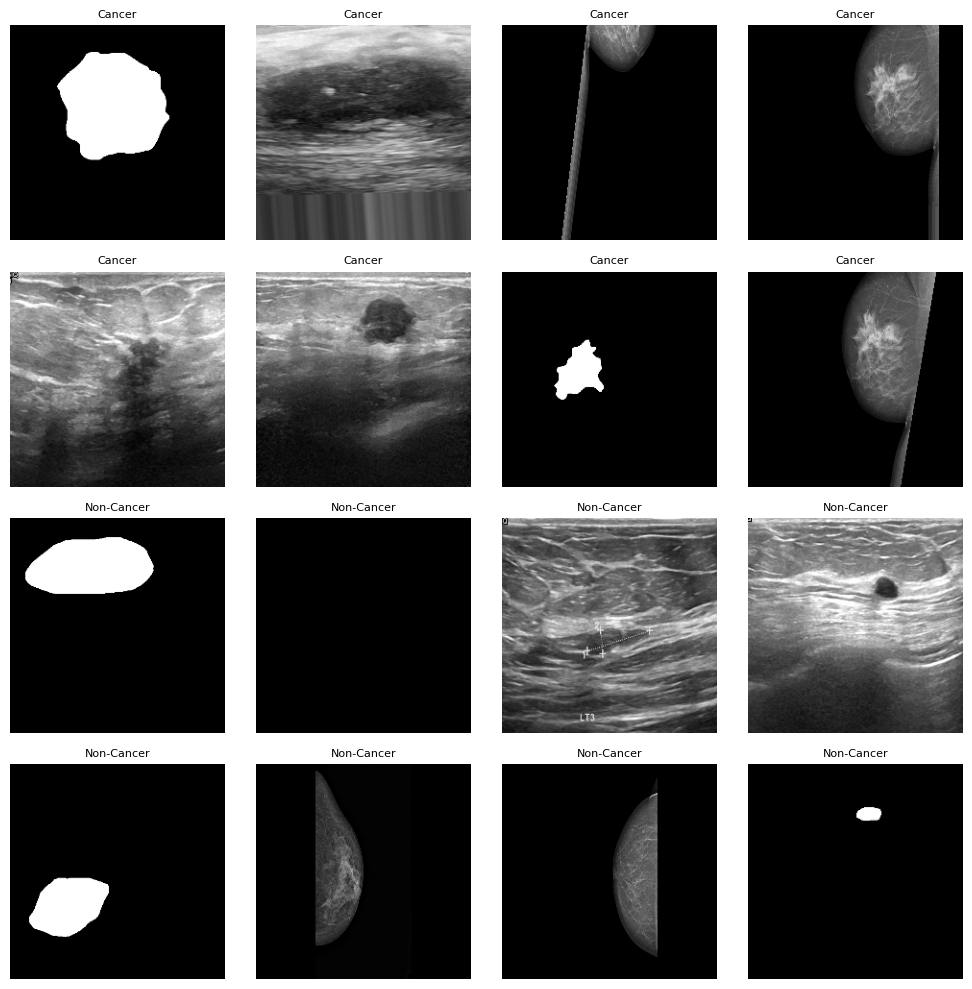

In [10]:
# Display a balanced set of images
display_balanced_images(X_train, y_train)

print(f"Final dataset size: {len(images)} images")
print(f"Training set size: {len(X_train)} images")
print(f"Test set size: {len(X_test)} images")

# Display Single Images

In [11]:
# Rescale Images for Display
def rescale_images(image_array):
    """Undo normalization and rescale image for correct display."""
    image_array = np.array(image_array)  # Ensure it's a NumPy array
    image_array = (image_array - image_array.min()) / (image_array.max() - image_array.min()) * 255
    return image_array.astype('uint8')

# Function to display a single image
def display_single_image(image, title):
    """Display a single image with correct scaling and title."""
    image = rescale_images(image)  # Undo normalization for correct display
    plt.imshow(image, cmap='gray')  # Set cmap='gray' if images are grayscale
    plt.title(title)
    plt.axis('off')
    plt.show()

Final dataset size: 3554 images
Training set size: 2843 images
Test set size: 711 images


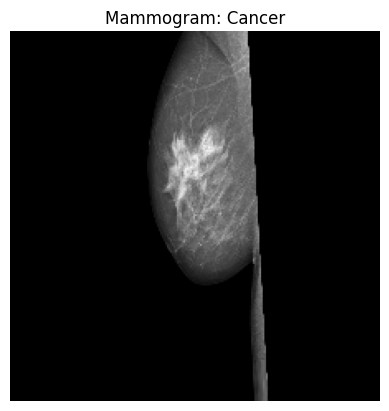

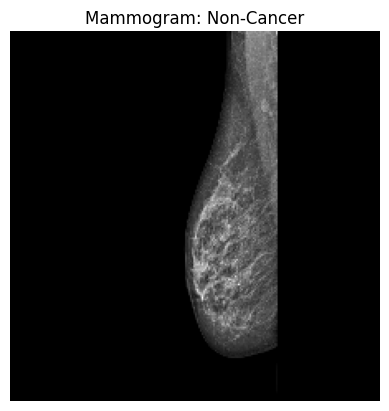

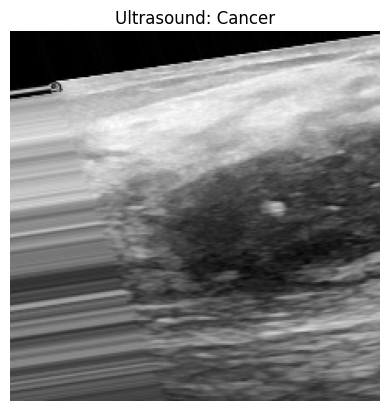

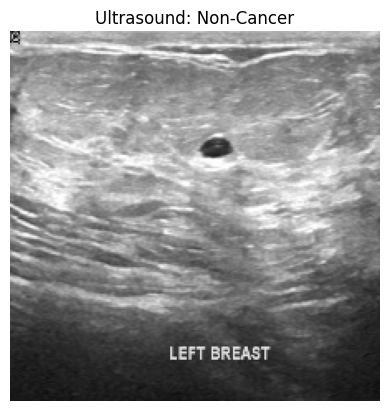

In [12]:
# Mammogram Dataset
if len(cancer_images) > 0:
    display_single_image(cancer_images[0][0], "Mammogram: Cancer")
if len(non_cancer_images) > 0:
    display_single_image(non_cancer_images[0][0], "Mammogram: Non-Cancer")

# Ultrasound Dataset
if len(ultrasound_cancer_images) > 0:  # Ensure valid variable name
    display_single_image(ultrasound_cancer_images[0][0], "Ultrasound: Cancer")
if len(ultrasound_non_cancer_images) > 0:  # Ensure valid variable name
    display_single_image(ultrasound_non_cancer_images[0][0], "Ultrasound: Non-Cancer")

# Tumor Highlight Function

In [13]:
def highlight_tumor_mass(image):
    """Highlights the tumor mass and returns the image with contours and tumor size."""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if len(image.shape) == 3 else image  # Ensure grayscale
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Adaptive thresholding for ultrasound, Otsu for mammogram
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Morphological operations
    kernel = np.ones((5, 5), np.uint8)
    clean_thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Find contours
    contours, _ = cv2.findContours(clean_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter small contours
    min_area = 0.005 * (gray.shape[0] * gray.shape[1])  # Adjusted to 0.5% of image area
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]

    # Draw contours on original image if any valid contours exist
    result = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR) if len(image.shape) == 2 else image.copy()
    tumor_size_pixels = 0
    if filtered_contours:
        cv2.drawContours(result, filtered_contours, -1, (0, 255, 0), 2)
        tumor_size_pixels = max([cv2.contourArea(cnt) for cnt in filtered_contours])  # Get the largest contour area

    return result, tumor_size_pixels

# Function to calculate real-world tumor size
def calculate_real_world_size(tumor_size_pixels, pixels_per_mm):
    """Convert tumor size from pixels to real-world units (e.g., millimeters)."""
    return tumor_size_pixels / pixels_per_mm

# Function to suggest treatment options
def suggest_treatment(tumor_size_mm):
    """Suggest treatment options based on tumor size."""
    if tumor_size_mm < 10:
        return "Lumpectomy or Radiation Therapy."
    elif 10 <= tumor_size_mm < 20:
        return "Surgery (Mastectomy) followed by Chemotherapy."
    else:
        
        return "Aggressive Chemotherapy and Radiation Therapy."

# Feature Extraction using ResNet and MobileNet

In [14]:
# Load Pretrained Models (without classification layers)
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Extract deep features using GAP (Global Average Pooling)
resnet_model = Model(inputs=resnet_base.input, outputs=GlobalAveragePooling2D()(resnet_base.output))
mobilenet_model = Model(inputs=mobilenet_base.input, outputs=GlobalAveragePooling2D()(mobilenet_base.output))

# Function to extract features
def extract_features(model, images):
    """Extracts deep features using a pretrained model."""
    return model.predict(images, batch_size=32, verbose=0)  # Set verbose=0 to suppress output

# Extract features using ResNet50 and MobileNetV2
resnet_features_train = extract_features(resnet_model, X_train)
mobilenet_features_train = extract_features(mobilenet_model, X_train)

resnet_features_test = extract_features(resnet_model, X_test)
mobilenet_features_test = extract_features(mobilenet_model, X_test)

# Concatenate extracted features from both models
X_train_features = np.concatenate([resnet_features_train, mobilenet_features_train], axis=1)
X_test_features = np.concatenate([resnet_features_test, mobilenet_features_test], axis=1)

# Verify the shape of concatenated features
print("ResNet features shape (train):", resnet_features_train.shape)  # Should be (2843, 2048)
print("MobileNet features shape (train):", mobilenet_features_train.shape)  # Should be (2843, 1280)
print("Concatenated features shape (train):", X_train_features.shape)  # Should be (2843, 3328)

print("ResNet features shape (test):", resnet_features_test.shape)  # Should be (711, 2048)
print("MobileNet features shape (test):", mobilenet_features_test.shape)  # Should be (711, 1280)
print("Concatenated features shape (test):", X_test_features.shape)  # Should be (711, 3328)

# Retrain the scaler on the correct features
scaler = StandardScaler()
scaler.fit(X_train_features)  # X_train_features has shape (2843, 3328)

# Save the updated scaler
joblib.dump(scaler, 'scaler.pkl')

# Scale the training features
X_train_scaled = scaler.transform(X_train_features)  # Add this line

# Scale the test features
X_test_scaled = scaler.transform(X_test_features)  # X_test_features has shape (711, 3328)

ResNet features shape (train): (2843, 2048)
MobileNet features shape (train): (2843, 1280)
Concatenated features shape (train): (2843, 3328)
ResNet features shape (test): (711, 2048)
MobileNet features shape (test): (711, 1280)
Concatenated features shape (test): (711, 3328)


# Training using Ensemble Model

In [15]:
# Train individual models
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weight_dict)
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
lr = LogisticRegression(max_iter=2000, solver='lbfgs', class_weight=class_weight_dict)

rf.fit(X_train_scaled, y_train.ravel())
xgb.fit(X_train_scaled, y_train.ravel())
lr.fit(X_train_scaled, y_train.ravel())

# Create an ensemble model using soft voting
ensemble_model = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb), ('lr', lr)],
    voting='soft'  # Use soft voting for better performance
)

# Train the ensemble model
ensemble_model.fit(X_train_scaled, y_train.ravel())

# Make predictions
ensemble_pred = ensemble_model.predict(X_test_scaled)

# Evaluate the ensemble model
ensemble_acc = accuracy_score(y_test, ensemble_pred)
print(f"Multi-Model Ensemble Accuracy: {ensemble_acc:.4f}")

# Print detailed classification report
print("\nEnsemble Model Classification Report:\n", classification_report(y_test, ensemble_pred))

Multi-Model Ensemble Accuracy: 0.9705

Ensemble Model Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       356
         1.0       0.98      0.96      0.97       355

    accuracy                           0.97       711
   macro avg       0.97      0.97      0.97       711
weighted avg       0.97      0.97      0.97       711



In [16]:
# Save the ensemble model
joblib.dump(ensemble_model, 'breast_cancer_ensemble.pkl')

['breast_cancer_ensemble.pkl']

In [17]:
# Load the saved scaler
scaler = joblib.load('scaler.pkl')

# Load the saved ensemble model
ensemble_model = joblib.load('breast_cancer_ensemble.pkl')

# Regenerate predictions
ensemble_pred = ensemble_model.predict(X_test_scaled)

# Visualization after Training

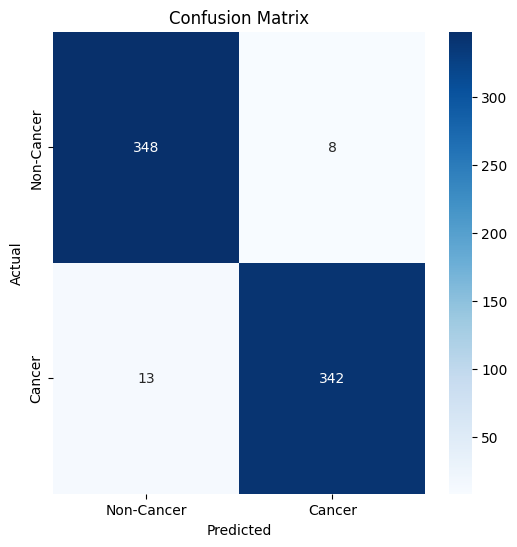

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate the confusion matrix
cm = confusion_matrix(y_test, ensemble_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Cancer', 'Cancer'], 
            yticklabels=['Non-Cancer', 'Cancer'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [20]:
# ROC curve and AUC

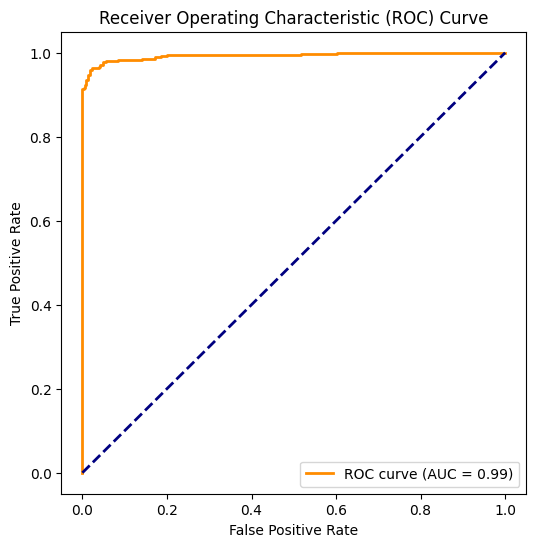

In [21]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class
y_pred_proba = ensemble_model.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [22]:
# Precision-Recall Curve

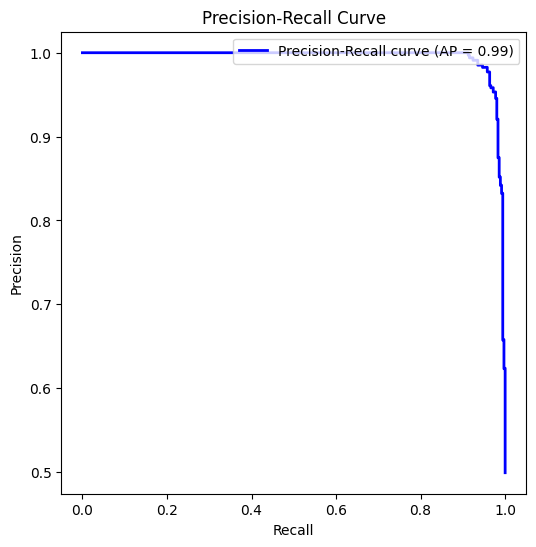

In [23]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

# Plot Precision-Recall curve
plt.figure(figsize=(6, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()

In [34]:
# Feature Importance (for Tree-Based Models)

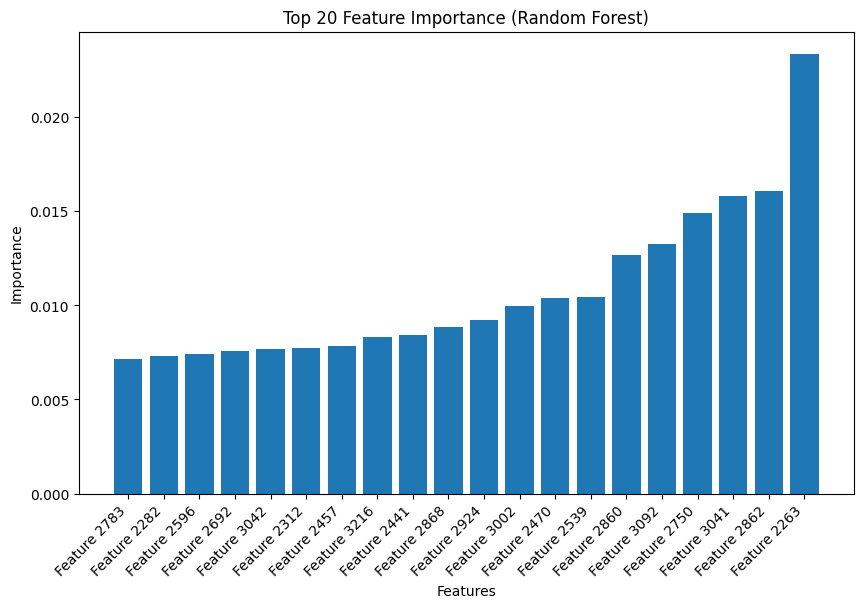

In [35]:
import numpy as np

# Get feature importances from the Random Forest model
importances = rf.feature_importances_

# Get the top N important features
N = 20
indices = np.argsort(importances)[-N:]  # Get indices of top N features

# Plot the top N feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(N), np.array(importances)[indices], align='center')
plt.xticks(range(N), [f'Feature {i}' for i in indices], rotation=45, ha='right', fontsize=10)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 20 Feature Importance (Random Forest)')
plt.show()

In [ ]:
# Distribution of Predicted Probabilities

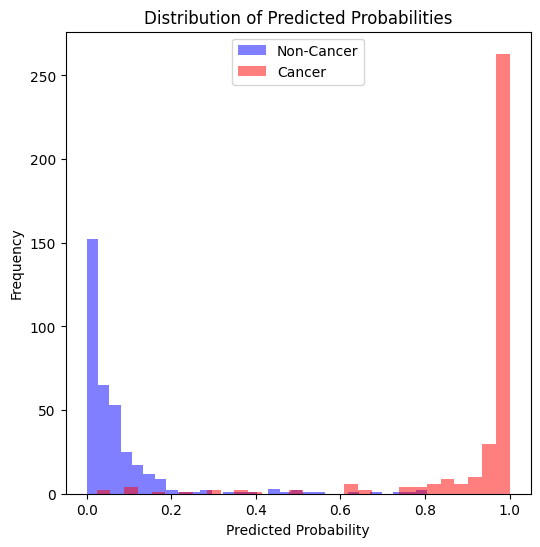

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Flatten y_test to make it 1D
y_test_flat = y_test.ravel()

plt.figure(figsize=(6, 6))

# Filter probabilities where y_test == 0 (Non-Cancer)
plt.hist(y_pred_proba[y_test_flat == 0], bins=30, alpha=0.5, label='Non-Cancer', color='blue')

# Filter probabilities where y_test == 1 (Cancer)
plt.hist(y_pred_proba[y_test_flat == 1], bins=30, alpha=0.5, label='Cancer', color='red')

plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.legend(loc="upper center")
plt.show()

In [51]:
# Model Comparison (Bar Plot)

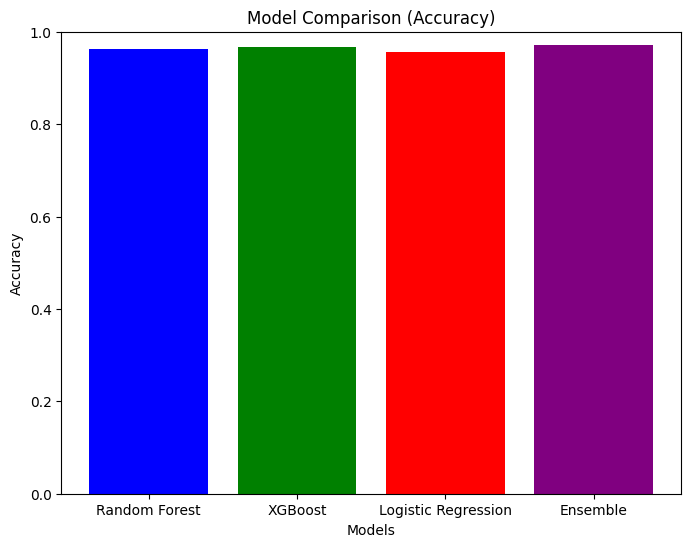

In [52]:
models = ['Random Forest', 'XGBoost', 'Logistic Regression', 'Ensemble']
accuracies = [accuracy_score(y_test, rf.predict(X_test_scaled)),
              accuracy_score(y_test, xgb.predict(X_test_scaled)),
              accuracy_score(y_test, lr.predict(X_test_scaled)),
              ensemble_acc]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Comparison (Accuracy)')
plt.ylim(0, 1)
plt.show()

In [53]:
# Class Distribution

C:\Users\Dell\AppData\Local\Temp\ipykernel_14196\3149746826.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train.ravel(), palette='Set2')


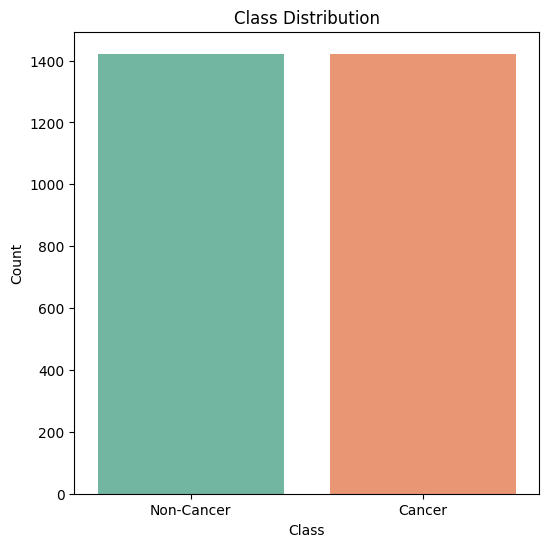

In [54]:
plt.figure(figsize=(6, 6))
sns.countplot(x=y_train.ravel(), palette='Set2')
plt.xticks([0, 1], ['Non-Cancer', 'Cancer'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow warnings
import tensorflow as tf
tf.get_logger().setLevel('ERROR')  # Suppress TensorFlow logging

import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk
import numpy as np
import cv2
import joblib
import threading

# Load the trained ensemble model
ensemble_model = joblib.load('breast_cancer_ensemble.pkl')

# Load the feature extraction models (ResNet50 and MobileNetV2)
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

# Load ResNet50 and MobileNetV2 without the top classification layer
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add Global Average Pooling to the base models
resnet_model = Model(inputs=resnet_base.input, outputs=GlobalAveragePooling2D()(resnet_base.output))
mobilenet_model = Model(inputs=mobilenet_base.input, outputs=GlobalAveragePooling2D()(mobilenet_base.output))

# Load the scaler
scaler = joblib.load('scaler.pkl')  # Ensure the scaler was trained on features with shape (2843, 3328)

# Function to preprocess the image
def preprocess_image(image_path):
    # Load and resize the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not load image: {image_path}")
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to extract features
def extract_features(img):
    # Extract features using ResNet50 and MobileNetV2
    resnet_features = resnet_model.predict(img, verbose=0)
    mobilenet_features = mobilenet_model.predict(img, verbose=0)
    
    # Debugging: Print feature shapes
    print(f"ResNet features shape: {resnet_features.shape}")
    print(f"MobileNet features shape: {mobilenet_features.shape}")
    
    # Ensure the features have the same shape as during training
    if resnet_features.shape[1] != 2048 or mobilenet_features.shape[1] != 1280:
        raise ValueError("Feature extraction mismatch! ResNet features should have 2048 dimensions, and MobileNet features should have 1280 dimensions.")
    
    # Concatenate features
    features = np.concatenate([resnet_features, mobilenet_features], axis=1)
    
    # Ensure the concatenated features have the correct shape
    if features.shape[1] != 3328:
        raise ValueError(f"Concatenated features should have 3328 dimensions, but got {features.shape[1]} dimensions.")
    
    # Scale the features
    features = scaler.transform(features)
    return features

# Function to highlight tumor and calculate size
def highlight_tumor_mass(image):
    """Highlights the tumor mass and returns the image with contours and tumor size."""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if len(image.shape) == 3 else image  # Ensure grayscale
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Adaptive thresholding for ultrasound, Otsu for mammogram
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Morphological operations
    kernel = np.ones((5, 5), np.uint8)
    clean_thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Find contours
    contours, _ = cv2.findContours(clean_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter small contours
    min_area = 0.005 * (gray.shape[0] * gray.shape[1])  # Adjusted to 0.5% of image area
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]

    # Draw contours on original image if any valid contours exist
    result = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR) if len(image.shape) == 2 else image.copy()
    tumor_size_pixels = 0
    if filtered_contours:
        cv2.drawContours(result, filtered_contours, -1, (0, 255, 0), 2)
        tumor_size_pixels = max([cv2.contourArea(cnt) for cnt in filtered_contours])  # Get the largest contour area

    return result, tumor_size_pixels

# Function to calculate real-world tumor size
def calculate_real_world_size(tumor_size_pixels, pixels_per_mm):
    """Convert tumor size from pixels to real-world units (e.g., millimeters)."""
    print(f"Tumor Size (pixels): {tumor_size_pixels}")
    print(f"Pixels per mm: {pixels_per_mm}")
    tumor_size_mm = tumor_size_pixels / pixels_per_mm
    print(f"Tumor Size (mm): {tumor_size_mm}")
    return tumor_size_mm

# Function to classify tumor stage based on size
def classify_tumor_stage(tumor_size_mm):
    """Classify tumor stage based on size (T1a, T1b, T1c, T2, T3, T4)."""
    if tumor_size_mm <= 5:
        return "T1a"
    elif 5 < tumor_size_mm <= 10:
        return "T1b"
    elif 10 < tumor_size_mm <= 20:
        return "T1c"
    elif 20 < tumor_size_mm <= 50:
        return "T2"
    elif 50 < tumor_size_mm:
        return "T3"
    else:
        return "T4"  # For tumors that have grown into the chest wall or skin

# Function to suggest treatment options
def suggest_treatment(tumor_stage):
    """Suggest treatment options based on tumor stage."""
    if tumor_stage in ["T1a", "T1b", "T1c"]:
        return "Lumpectomy or Radiation Therapy."
    elif tumor_stage == "T2":
        return "Surgery (Mastectomy) followed by Chemotherapy."
    elif tumor_stage == "T3":
        return "Aggressive Chemotherapy and Radiation Therapy."
    elif tumor_stage == "T4":
        return "Combination of Surgery, Chemotherapy, and Radiation Therapy."
    else:
        return "Consult an oncologist for personalized treatment."

# Function to make predictions
def predict_image(image_path):
    try:
        # Preprocess the image
        img = preprocess_image(image_path)
        print("Image preprocessed successfully.")
        
        # Extract features
        features = extract_features(img)
        print("Features extracted successfully.")
        
        # Make prediction
        prediction = ensemble_model.predict(features)
        print("Prediction made successfully.")
        
        # Debugging: Print raw prediction probabilities
        print(f"Raw prediction probabilities: {prediction}")
        
        result = "Cancer" if prediction[0] == 1 else "Non-Cancer"
        print(f"Prediction result: {result}")  # Debugging: Print the result

        # If cancer is detected, highlight tumor and calculate size
        if result == "Cancer":
            original_image = cv2.imread(image_path)
            original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
            highlighted_image, tumor_size_pixels = highlight_tumor_mass(original_image)
            
            # Convert tumor size to millimeters
            pixels_per_mm = 10.0  # Adjust this based on your image resolution
            tumor_size_mm = calculate_real_world_size(tumor_size_pixels, pixels_per_mm)
            
            # Classify tumor stage
            tumor_stage = classify_tumor_stage(tumor_size_mm)
            
            # Suggest treatment based on tumor stage
            treatment_suggestion = suggest_treatment(tumor_stage)
            return result, highlighted_image, tumor_size_mm, tumor_stage, treatment_suggestion
        else:
            return result, None, None, None, None

    except Exception as e:
        print(f"Error in predict_image: {str(e)}")
        raise

# Tkinter GUI
class BreastCancerApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Breast Cancer Detection")
        self.root.geometry("600x500")  # Increased window size

        # Title Label
        self.title_label = tk.Label(root, text="Breast Cancer Detection", font=("Arial", 16))
        self.title_label.pack(pady=10)

        # Image Display
        self.image_label = tk.Label(root)
        self.image_label.pack(pady=10)

        # Upload Button
        self.upload_button = tk.Button(root, text="Upload Image", command=self.upload_image)
        self.upload_button.pack(pady=10)

        # Predict Button
        self.predict_button = tk.Button(root, text="Predict", command=self.predict, state=tk.DISABLED)
        self.predict_button.pack(pady=10)

        # Result Frame
        self.result_frame = tk.Frame(root)
        self.result_frame.pack(pady=10)

        # Prediction Label
        self.prediction_label = tk.Label(self.result_frame, text="Prediction: ", font=("Arial", 12))
        self.prediction_label.grid(row=0, column=0, sticky="w")

        # Tumor Size Label
        self.tumor_size_label = tk.Label(self.result_frame, text="Tumor Size: ", font=("Arial", 12))
        self.tumor_size_label.grid(row=1, column=0, sticky="w")

        # Tumor Stage Label
        self.tumor_stage_label = tk.Label(self.result_frame, text="Tumor Stage: ", font=("Arial", 12))
        self.tumor_stage_label.grid(row=2, column=0, sticky="w")

        # Treatment Label
        self.treatment_label = tk.Label(self.result_frame, text="Treatment: ", font=("Arial", 12))
        self.treatment_label.grid(row=3, column=0, sticky="w")

        # Image Path
        self.image_path = None

        # Reference to the current PhotoImage object
        self.current_image = None

    def upload_image(self):
        # Open file dialog to select an image
        self.image_path = filedialog.askopenfilename(filetypes=[("Image Files", "*.jpg;*.jpeg;*.png")])
        if self.image_path:
            try:
                # Display the image
                img = Image.open(self.image_path)
                img = img.resize((224, 224), Image.Resampling.LANCZOS)  # Updated line
                img_tk = ImageTk.PhotoImage(img)
                self.image_label.config(image=img_tk)
                self.image_label.image = img_tk  # Keep a reference to avoid garbage collection

                # Store the PhotoImage object in self.current_image
                self.current_image = img_tk

                # Enable the predict button
                self.predict_button.config(state=tk.NORMAL)

                # Clear previous results
                self.prediction_label.config(text="Prediction: ")
                self.tumor_size_label.config(text="Tumor Size: ")
                self.tumor_stage_label.config(text="Tumor Stage: ")
                self.treatment_label.config(text="Treatment: ")
            except Exception as e:
                messagebox.showerror("Error", f"Failed to load image: {str(e)}")

    def predict(self):
        if self.image_path:
            # Disable the predict button while processing
            self.predict_button.config(state=tk.DISABLED)
            self.prediction_label.config(text="Processing...")
            self.tumor_size_label.config(text="")
            self.tumor_stage_label.config(text="")
            self.treatment_label.config(text="")

            # Run the prediction in a separate thread
            threading.Thread(target=self._predict_image, args=(self.image_path,)).start()
        else:
            messagebox.showerror("Error", "Please upload an image first.")

    def _predict_image(self, image_path):
        try:
            # Make prediction
            result, highlighted_image, tumor_size_mm, tumor_stage, treatment_suggestion = predict_image(image_path)
            if result == "Cancer":
                # Display the highlighted image
                highlighted_image = Image.fromarray(highlighted_image)
                highlighted_image = highlighted_image.resize((224, 224), Image.Resampling.LANCZOS)
                highlighted_img_tk = ImageTk.PhotoImage(highlighted_image)
                self.image_label.config(image=highlighted_img_tk)
                self.image_label.image = highlighted_img_tk  # Keep a reference

                # Store the PhotoImage object in self.current_image
                self.current_image = highlighted_img_tk

                # Update the result labels
                self.prediction_label.config(text=f"Prediction: {result}")
                self.tumor_size_label.config(text=f"Tumor Size: {tumor_size_mm:.2f} mm")
                self.tumor_stage_label.config(text=f"Tumor Stage: {tumor_stage}")
                self.treatment_label.config(text=f"Treatment: {treatment_suggestion}")
            else:
                self.prediction_label.config(text=f"Prediction: {result}")
                self.tumor_size_label.config(text="")
                self.tumor_stage_label.config(text="")
                self.treatment_label.config(text="")
        except Exception as e:
            messagebox.showerror("Error", f"An error occurred: {str(e)}")
        finally:
            # Re-enable the predict button
            self.predict_button.config(state=tk.NORMAL)

# Run the app
if __name__ == "__main__":
    root = tk.Tk()
    app = BreastCancerApp(root)
    root.mainloop()

Image preprocessed successfully.
ResNet features shape: (1, 2048)
MobileNet features shape: (1, 1280)
Features extracted successfully.
Prediction made successfully.
Raw prediction probabilities: [1.]
Prediction result: Cancer
Tumor Size (pixels): 1165910.5
Pixels per mm: 10.0
Tumor Size (mm): 116591.05
